<a href="https://colab.research.google.com/github/vig-c/Forecasting-asset-prices-using-Python/blob/main/B216927.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing packages and data**

In [ ]:
# Importing necessary libraries and packages
import os
import random
import tqdm
import numpy as np
import pandas as pd

!pip install shap
import shap

# Allowing GPU memory growth
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K

from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential
from scipy import stats
from keras.optimizers import Adam

from pprint import pprint
from pylab import plt, mpl

# Setting plotting style and options
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASHSEED'] = '0'

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import *
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline

%matplotlib inline

# These options determine the way floating point numbers are displayed.
np.set_printoptions(precision=4, suppress=True)

tf.random.set_seed(100)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [ ]:
# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# If there is at least one GPU available, set it to be used
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Set visible devices to be used
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Print the available and logical GPUs
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
        # In case of any errors, fall back to CPU
        print(e)
        device = '/device:CPU:0'

else:
    print("No GPUs available, using CPU instead")
    device = '/device:CPU:0'

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# Loading data from CSV file
data = pd.read_csv(('/drive/My Drive/Colab Notebooks/Data/equity_2000_2020.csv'), parse_dates=['DATE'])

# **Pre-processing the data**

In [ ]:
# Converting the date coulmn in the data
data.sort_values('DATE', inplace=True)
data.set_index('DATE', inplace=True)

# Remove any useless column in raw dataset and remove DATE once converted to datetime
data.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
# Filter data from 2016-2020
df = data['2016-01-01':'2020-12-31']

df.head(10)

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


,permno,RET,mvel1,prc,SHROUT,beta,betasq,chmom,dolvol,idiovol,...,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,bm,bm_ia
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-29,85627.0,-0.247803,8.598956e+05,17.120001,37781.0,1.440326,2.074539,0.074746,13.904379,0.029764,...,0.021471,1.860000e-09,0.023656,0.013945,0.578404,6.644560,9.710000e-09,55.0,0.684283,0.156429
2016-01-29,85659.0,-0.023189,2.526963e+04,1.230000,20068.0,0.352673,0.124378,-0.499511,5.576631,0.075175,...,0.044946,5.190000e-06,0.048000,0.019261,1.448473,0.764197,9.545457e-01,67.0,0.956329,0.284501
2016-01-29,85656.0,-0.034162,6.805470e+04,15.550000,4227.0,0.230218,0.053000,0.058169,8.386857,0.022767,...,0.027185,7.880000e-05,0.039994,0.022588,2.343109,0.280833,3.818182e+00,60.0,0.893174,0.053981
2016-01-29,85653.0,-0.160998,3.032448e+05,11.100000,22921.0,1.052777,1.108340,-0.056030,13.201845,0.024467,...,0.032151,4.550000e-09,0.059843,0.027408,0.537101,20.400513,4.850000e-09,67.0,1.071475,0.585934
2016-01-29,85645.0,0.050918,6.856873e+06,100.720001,71545.0,0.806705,0.650773,0.261942,15.788708,0.025336,...,0.019611,3.540000e-10,0.023979,0.014187,0.400880,2.187645,1.670000e-08,20.0,0.386593,-0.084692
2016-01-29,85636.0,-0.015485,2.617266e+07,64.849998,397481.0,0.796075,0.633736,0.037204,14.903498,0.021070,...,0.016865,4.670000e-10,0.016619,0.013492,0.352402,0.310542,9.190000e-08,60.0,0.486023,-79.101214
2016-01-29,85631.0,-0.231577,1.372893e+07,46.820000,224400.0,1.484511,2.203772,0.383025,17.676199,0.034998,...,0.022034,1.140000e-10,0.019694,0.014606,0.525608,4.418726,1.140000e-08,73.0,0.162401,-0.210667
2016-01-29,85621.0,-0.077492,9.277580e+06,312.850006,27357.0,1.034891,1.070999,-0.135766,16.504112,0.020466,...,0.019949,1.970000e-10,0.019719,0.011590,0.459760,2.514650,1.540000e-08,38.0,0.089911,-0.299173
2016-01-29,85570.0,0.055133,9.402776e+04,5.550000,17876.0,0.292214,0.085389,-0.170599,11.281461,0.084464,...,0.084042,7.270000e-08,0.270983,0.067673,1.115260,20.988883,7.250000e-09,49.0,-0.200669,-0.934037


In [ ]:
# Print information regarding dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345618 entries, 2016-01-29 to 2020-12-31
Data columns (total 100 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   permno           345618 non-null  float64
 1   RET              345618 non-null  float64
 2   mvel1            345618 non-null  float64
 3   prc              345618 non-null  float64
 4   SHROUT           345618 non-null  float64
 5   beta             345618 non-null  float64
 6   betasq           345618 non-null  float64
 7   chmom            345618 non-null  float64
 8   dolvol           345618 non-null  float64
 9   idiovol          345618 non-null  float64
 10  indmom           345618 non-null  float64
 11  mom1m            345618 non-null  float64
 12  mom6m            345618 non-null  float64
 13  mom12m           345618 non-null  float64
 14  mom36m           345618 non-null  float64
 15  mve0             345618 non-null  float64
 16  pricedelay       3456

# **Sampling of data**

In [ ]:
# Assigning train or test label
Time_diff = df.index[-1] - df.index[0]
print(Time_diff.days, 'days in the dataset')
print(np.count_nonzero(df['permno'].unique()), 'stocks in total in the datasets')

1798 days in the dataset
7766 stocks in total in the datasets


In [ ]:
# Ratio of data for test
test_ratio = 0.2

In [ ]:
# Index splitting train and test data
test_index = df.index[0] + (Time_diff*(1-test_ratio))

In [ ]:
# Create a new column of test flag
df['test_flag'] = False # All false for training
df.loc[ test_index : df.index[-1], 'test_flag' ] = True # Some data for testing based on test_ratio


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


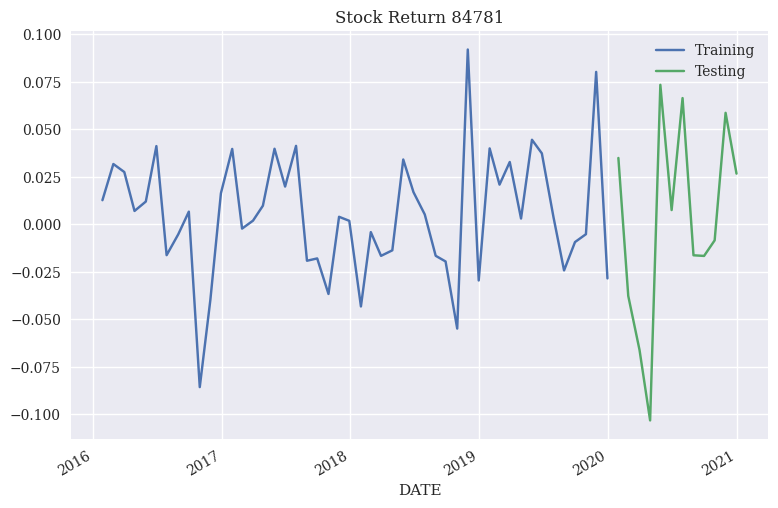

In [ ]:
# Plot series for selected stock
def plot_stock(stockID):
  plt.figure(figsize=(9,6))
  df[(df['permno']==stockID)&(df['test_flag']==False)]['RET'].plot()
  df[(df['permno']==stockID)&(df['test_flag']==True)]['RET'].plot()
  plt.title('Stock Return'+' '+str(stockID))
  plt.legend(['Training','Testing'])
  plt.show()

# Example usage
plot_stock(84781)

# **Autoencoder + LSTM Model**

In [ ]:
# Creating a generator for LSTM Windows and Labels
sequence_length = 8

# Setting seed for reproducibility
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

# Function to generate LSTM input sequences
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# Function to generate LSTM output labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [ ]:
# Train/Test practice data preparation
col = df.columns

# Splitting data into training and testing sets
X_train, X_test = [], []
y_train, y_test = [], []

for (stock,is_test), _df in df.groupby(['permno', 'test_flag']):
    
    for seq in gen_sequence(_df, sequence_length, col):        
        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)
                
    for seq in gen_labels(_df, sequence_length, ['RET']):        
        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)

# Converting the list into arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print shapes of the input X and output Y
print('shape of the intput X and output y\ninput training data dimension: ')
print(X_train.shape)
print('\noutput training data dimension: ')
print(y_train.shape)

print('\ninput testing data dimension: ')
print(X_test.shape)
print('\noutput testing data dimension: ')
print(y_test.shape)

# Print several examples of input and output data
for i in range(3):
    print('input ', i, ': \n',X_train[i,:,0:3])
    print('==> output ', i, ': \n', y_train[i], '\n')

shape of the intput X and output y
input training data dimension: 
(219580, 8, 101)

output training data dimension: 
(219580, 1)

input testing data dimension: 
(22346, 8, 101)

output testing data dimension: 
(22346, 1)
input  0 : 
 [[10001.0 0.116779 78262.248]
 [10001.0 -0.055288 87401.59679]
 [10001.0 -0.006361 82569.3014]
 [10001.0 -0.055698 82067.4794]
 [10001.0 -0.021918 76737.60201]
 [10001.0 -0.021008 75055.6786]
 [10001.0 0.026466 73478.87759]
 [10001.0 0.03662 74635.199]]
==> output  0 : 
 [0.0421] 

input  1 : 
 [[10001.0 -0.055288 87401.59679]
 [10001.0 -0.006361 82569.3014]
 [10001.0 -0.055698 82067.4794]
 [10001.0 -0.021918 76737.60201]
 [10001.0 -0.021008 75055.6786]
 [10001.0 0.026466 73478.87759]
 [10001.0 0.03662 74635.199]
 [10001.0 0.04212 77397.7614]]
==> output  1 : 
 [0.6199] 

input  2 : 
 [[10001.0 -0.006361 82569.3014]
 [10001.0 -0.055698 82067.4794]
 [10001.0 -0.021918 76737.60201]
 [10001.0 -0.021008 75055.6786]
 [10001.0 0.026466 73478.87759]
 [10001.0 0.

In [ ]:
# Standardizing of data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

# Printing the shape of data
print(X_train.shape)

(219580, 8, 101)


# **Autoencoder training**

In [ ]:
# Setting the seed for reproducibility
tf.random.set_seed(50)

# Specify the GPU device to use
with tf.device('/GPU:0'):
    # Defining the input shape and layers for encoding and decoding
    inputs_ae = Input(shape=(X_train.shape[1:]))

    # Encoding LSTM layer, receive inputs_ae from input layer
    encoded_ae_2 = LSTM(int(X_train.shape[2] * 1.4), return_sequences=True, dropout=0.4)(inputs_ae, training=True)
    encoded_ae_2 = BatchNormalization()(encoded_ae_2)

    # Decoding LSTM layer, receive encoded_ae from encoding LSTM layer
    decoded_ae = LSTM(int(X_train.shape[2] / 2), return_sequences=True, dropout=0.4)(encoded_ae_2, training=True)
    out_ae = TimeDistributed(Dense(1))(decoded_ae)
    decoded_ae = BatchNormalization()(decoded_ae)

    # Compiling the autoencoder model and setting the loss function and optimizer
    sequence_autoencoder = Model(inputs_ae, out_ae)
    sequence_autoencoder.compile(optimizer='adam', loss='mse')

    # Training the autoencoder with early stopping and reconstructing the input as output
    es = EarlyStopping(patience=15, verbose=2, min_delta=0.001, 
                           monitor='val_loss', mode='auto', restore_best_weights=True)

    sequence_autoencoder.fit(X_train, X_train, validation_data=(X_train, X_train),
                                 batch_size=256, epochs=150, verbose=1, callbacks=[es])

Epoch 1/150
858/858 [==============================] - 20s 12ms/step - loss: 0.9821 - val_loss: 0.9768
Epoch 2/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9765 - val_loss: 0.9762
Epoch 3/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9761 - val_loss: 0.9759
Epoch 4/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9759 - val_loss: 0.9758
Epoch 5/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9758 - val_loss: 0.9757
Epoch 6/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9757 - val_loss: 0.9756
Epoch 7/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9756 - val_loss: 0.9756
Epoch 8/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9756 - val_loss: 0.9755
Epoch 9/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9756 - val_loss: 0.9755
Epoch 10/150
858/858 [==============================] - 8s 9ms/step - loss: 0.9755 - val_

In [ ]:
# Define an encoder model to encode price and output the encoded features
encoder = Model(inputs_ae, encoded_ae_2)

# Encode the price features for train and test sets
encoded_feature_train = encoder.predict(X_train)
encoded_feature_test = encoder.predict(X_test)

# Print the dimension of the encoded features
print('encoded features: ', encoded_feature_train.shape)

# Concatenate the encoded price features with the original regressors
X_train_ = np.concatenate([X_train, encoder.predict(X_train)], axis=-1)
X_test_ = np.concatenate([X_test, encoder.predict(X_test)], axis=-1)

# Print the shape of the concatenated train and test sets
X_train_.shape, X_test_.shape

699/699 [==============================] - 1s 2ms/step
encoded features:  (219580, 8, 141)
699/699 [==============================] - 1s 2ms/step


((219580, 8, 242), (22346, 8, 242))

In [ ]:
%%time

# Set seed for reproducibility
set_seed(50)

# Define standard LSTM forecaster
with tf.device('/GPU:0'):
    inputs = Input(shape=(X_train_.shape[1:]))
    lstm = LSTM(256, return_sequences=True, dropout=0.4)(inputs, training=True)
    lstm = LSTM(128, return_sequences=False, dropout=0.4)(lstm, training=True)
    dense = Dense(50)(lstm)
    out = Dense(1)(dense)

    model = Model(inputs, out)
    model.compile(loss='mse', optimizer='adam')

# Fit the model on the GPU device
with tf.device('/GPU:0'):
    es = EarlyStopping(patience=15, verbose=2, min_delta=0.001, 
                       monitor='val_loss', mode='auto', restore_best_weights=True)
    model.fit(X_train_, y_train, validation_data=(X_train_, y_train), 
              epochs=150, batch_size=256, verbose=1, callbacks=[es])

Epoch 1/150
858/858 [==============================] - 13s 11ms/step - loss: 0.0259 - val_loss: 0.0247
Epoch 2/150
858/858 [==============================] - 7s 9ms/step - loss: 0.0246 - val_loss: 0.0244
Epoch 3/150
858/858 [==============================] - 7s 9ms/step - loss: 0.0245 - val_loss: 0.0244
Epoch 4/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0244 - val_loss: 0.0244
Epoch 5/150
858/858 [==============================] - 7s 9ms/step - loss: 0.0244 - val_loss: 0.0243
Epoch 6/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0243 - val_loss: 0.0243
Epoch 7/150
858/858 [==============================] - 7s 9ms/step - loss: 0.0243 - val_loss: 0.0242
Epoch 8/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0242 - val_loss: 0.0241
Epoch 9/150
858/858 [==============================] - 7s 9ms/step - loss: 0.0241 - val_loss: 0.0240
Epoch 10/150
858/858 [==============================] - 7s 9ms/step - loss: 0.0240 - val_

In [ ]:
# Evaluate model on test set
mse = model.evaluate(X_test_, y_test, verbose=0)

# Get model predictions on test set
y_pred = model.predict(X_test_)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Autoencoder + LSTM MSE: {mse:.4f}")
print(f"Autoencoder + LSTM MAE: {mae:.4f}")

699/699 [==============================] - 2s 2ms/step
Autoencoder + LSTM MSE: 0.0649
Autoencoder + LSTM MAE: 0.1410


In [ ]:
# Compute stochastic dropout
%%time
scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test_).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/100 [00:00<?, ?it/s]

699/699 [==============================] - 2s 2ms/step


  1%|          | 1/100 [00:02<03:27,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


  2%|▏         | 2/100 [00:04<03:25,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


  3%|▎         | 3/100 [00:06<03:22,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


  4%|▍         | 4/100 [00:08<03:20,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


  5%|▌         | 5/100 [00:10<03:18,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


  7%|▋         | 7/100 [00:14<03:15,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


  8%|▊         | 8/100 [00:16<03:12,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


  9%|▉         | 9/100 [00:18<03:09,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 10%|█         | 10/100 [00:20<03:07,  2.08s/it]

699/699 [==============================] - 2s 2ms/step


 11%|█         | 11/100 [00:23<03:07,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 12%|█▏        | 12/100 [00:25<03:05,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 13%|█▎        | 13/100 [00:27<03:03,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 14%|█▍        | 14/100 [00:29<03:02,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 15%|█▌        | 15/100 [00:31<03:00,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 16%|█▌        | 16/100 [00:33<02:58,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 17%|█▋        | 17/100 [00:35<02:56,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 18%|█▊        | 18/100 [00:37<02:54,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 19%|█▉        | 19/100 [00:40<02:52,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 20%|██        | 20/100 [00:42<02:49,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 21%|██        | 21/100 [00:44<02:46,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 22%|██▏       | 22/100 [00:46<02:43,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 23%|██▎       | 23/100 [00:48<02:41,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 24%|██▍       | 24/100 [00:50<02:39,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 25%|██▌       | 25/100 [00:52<02:36,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 26%|██▌       | 26/100 [00:54<02:34,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 27%|██▋       | 27/100 [00:56<02:32,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 28%|██▊       | 28/100 [00:58<02:29,  2.08s/it]

699/699 [==============================] - 2s 2ms/step


 29%|██▉       | 29/100 [01:00<02:28,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 30%|███       | 30/100 [01:03<02:27,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 31%|███       | 31/100 [01:05<02:24,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 32%|███▏      | 32/100 [01:07<02:22,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 33%|███▎      | 33/100 [01:09<02:20,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 34%|███▍      | 34/100 [01:11<02:19,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 35%|███▌      | 35/100 [01:13<02:17,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 36%|███▌      | 36/100 [01:15<02:15,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 37%|███▋      | 37/100 [01:17<02:13,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 38%|███▊      | 38/100 [01:19<02:10,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 39%|███▉      | 39/100 [01:21<02:08,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 40%|████      | 40/100 [01:24<02:05,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 41%|████      | 41/100 [01:26<02:03,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 42%|████▏     | 42/100 [01:28<02:03,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 43%|████▎     | 43/100 [01:30<02:00,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 44%|████▍     | 44/100 [01:32<01:57,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 45%|████▌     | 45/100 [01:34<01:55,  2.09s/it]

699/699 [==============================] - 2s 2ms/step


 46%|████▌     | 46/100 [01:36<01:54,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 47%|████▋     | 47/100 [01:38<01:52,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 48%|████▊     | 48/100 [01:40<01:49,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 49%|████▉     | 49/100 [01:43<01:47,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 50%|█████     | 50/100 [01:45<01:45,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 51%|█████     | 51/100 [01:47<01:43,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 52%|█████▏    | 52/100 [01:49<01:40,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 53%|█████▎    | 53/100 [01:51<01:38,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 54%|█████▍    | 54/100 [01:53<01:37,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 55%|█████▌    | 55/100 [01:55<01:35,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 56%|█████▌    | 56/100 [01:57<01:32,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 57%|█████▋    | 57/100 [01:59<01:30,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 58%|█████▊    | 58/100 [02:02<01:28,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 59%|█████▉    | 59/100 [02:04<01:27,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 60%|██████    | 60/100 [02:06<01:24,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 61%|██████    | 61/100 [02:08<01:22,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 62%|██████▏   | 62/100 [02:10<01:20,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 63%|██████▎   | 63/100 [02:12<01:18,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 64%|██████▍   | 64/100 [02:14<01:16,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 65%|██████▌   | 65/100 [02:16<01:14,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 66%|██████▌   | 66/100 [02:19<01:12,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 67%|██████▋   | 67/100 [02:21<01:09,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 68%|██████▊   | 68/100 [02:23<01:07,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 69%|██████▉   | 69/100 [02:25<01:05,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 70%|███████   | 70/100 [02:27<01:03,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 71%|███████   | 71/100 [02:29<01:01,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 72%|███████▏  | 72/100 [02:31<00:59,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 73%|███████▎  | 73/100 [02:33<00:56,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 74%|███████▍  | 74/100 [02:35<00:55,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 75%|███████▌  | 75/100 [02:38<00:52,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 76%|███████▌  | 76/100 [02:40<00:50,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 77%|███████▋  | 77/100 [02:42<00:48,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 78%|███████▊  | 78/100 [02:44<00:46,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 79%|███████▉  | 79/100 [02:46<00:44,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 80%|████████  | 80/100 [02:48<00:42,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 81%|████████  | 81/100 [02:50<00:39,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 82%|████████▏ | 82/100 [02:52<00:38,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 83%|████████▎ | 83/100 [02:55<00:36,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 84%|████████▍ | 84/100 [02:57<00:33,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 85%|████████▌ | 85/100 [02:59<00:31,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 86%|████████▌ | 86/100 [03:01<00:29,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 87%|████████▋ | 87/100 [03:03<00:27,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 88%|████████▊ | 88/100 [03:05<00:25,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 89%|████████▉ | 89/100 [03:07<00:23,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 90%|█████████ | 90/100 [03:09<00:21,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 91%|█████████ | 91/100 [03:11<00:19,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 92%|█████████▏| 92/100 [03:13<00:16,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 93%|█████████▎| 93/100 [03:16<00:14,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 94%|█████████▍| 94/100 [03:18<00:12,  2.13s/it]

699/699 [==============================] - 2s 2ms/step


 95%|█████████▌| 95/100 [03:20<00:10,  2.12s/it]

699/699 [==============================] - 2s 2ms/step


 96%|█████████▌| 96/100 [03:22<00:08,  2.11s/it]

699/699 [==============================] - 2s 2ms/step


 97%|█████████▋| 97/100 [03:24<00:06,  2.10s/it]

699/699 [==============================] - 2s 2ms/step


 98%|█████████▊| 98/100 [03:26<00:04,  2.20s/it]

699/699 [==============================] - 2s 2ms/step


 99%|█████████▉| 99/100 [03:29<00:02,  2.17s/it]

699/699 [==============================] - 2s 2ms/step


100%|██████████| 100/100 [03:31<00:00,  2.11s/it]

0.14100622722869305 0.00022625525867069223
CPU times: user 4min 33s, sys: 34.6 s, total: 5min 8s
Wall time: 3min 31s


In [ ]:
# Printing results of evaluation for Autoencoder+LSTM Model
results = {'LSTM':None, 'Autoencoder+LSTM':None}
results['Autoencoder+LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}
print(results)

{'LSTM': None, 'Autoencoder+LSTM': {'mean': 0.14100622722869305, 'std': 0.00022625525867069223}}


# **Simple LSTM Model**

In [ ]:
# Initializing and setting seed
set_seed(50)

# Defining simple LSTM model
inputs = Input(shape=(X_train.shape[1:]))
lstm = LSTM(256, return_sequences=True, dropout=0.4)(inputs, training=True)
lstm = LSTM(128, return_sequences=False, dropout=0.4)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

# Compiling model
model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

# Fitting the model on training data and early stopping during training to prevent overfitting
es = EarlyStopping(patience=15, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_train, y_train), 
          epochs=150, batch_size=256, verbose=1, callbacks=[es])

Epoch 1/150
858/858 [==============================] - 12s 10ms/step - loss: 0.0254 - val_loss: 0.0247
Epoch 2/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0247 - val_loss: 0.0244
Epoch 3/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0245 - val_loss: 0.0243
Epoch 4/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0244 - val_loss: 0.0242
Epoch 5/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0244 - val_loss: 0.0243
Epoch 6/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0243 - val_loss: 0.0242
Epoch 7/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0242 - val_loss: 0.0239
Epoch 8/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0241 - val_loss: 0.0239
Epoch 9/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 10/150
858/858 [==============================] - 7s 8ms/step - loss: 0.0239 - val_

In [ ]:
# Evaluate model on test set
mse = model.evaluate(X_test, y_test, verbose=0)

# Get model predictions on test set
y_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Simple LSTM -  MSE: {mse:.4f}")
print(f"Simple LSTM -  MAE: {mae:.4f}")

699/699 [==============================] - 3s 2ms/step
Simple LSTM -  MSE: 0.0622
Simple LSTM -  MAE: 0.1359


In [ ]:
# Compute stochastic dropout
scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/100 [00:00<?, ?it/s]

699/699 [==============================] - 2s 2ms/step


  1%|          | 1/100 [00:01<03:17,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


  2%|▏         | 2/100 [00:04<03:17,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


  3%|▎         | 3/100 [00:06<03:13,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


  4%|▍         | 4/100 [00:07<03:11,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


  5%|▌         | 5/100 [00:09<03:08,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


  6%|▌         | 6/100 [00:11<03:06,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


  7%|▋         | 7/100 [00:13<03:04,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


  8%|▊         | 8/100 [00:15<03:03,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


  9%|▉         | 9/100 [00:17<03:00,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 10%|█         | 10/100 [00:19<02:58,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 11%|█         | 11/100 [00:21<02:56,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 12%|█▏        | 12/100 [00:23<02:54,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 13%|█▎        | 13/100 [00:25<02:52,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 14%|█▍        | 14/100 [00:27<02:52,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 15%|█▌        | 15/100 [00:29<02:50,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 16%|█▌        | 16/100 [00:31<02:47,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 17%|█▋        | 17/100 [00:33<02:46,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 18%|█▊        | 18/100 [00:35<02:46,  2.04s/it]

699/699 [==============================] - 2s 2ms/step


 19%|█▉        | 19/100 [00:37<02:43,  2.02s/it]

699/699 [==============================] - 2s 2ms/step


 20%|██        | 20/100 [00:39<02:41,  2.02s/it]

699/699 [==============================] - 2s 2ms/step


 21%|██        | 21/100 [00:41<02:39,  2.02s/it]

699/699 [==============================] - 2s 2ms/step


 22%|██▏       | 22/100 [00:43<02:36,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 23%|██▎       | 23/100 [00:45<02:34,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 24%|██▍       | 24/100 [00:47<02:31,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 25%|██▌       | 25/100 [00:49<02:28,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 26%|██▌       | 26/100 [00:51<02:27,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 27%|██▋       | 27/100 [00:53<02:26,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 28%|██▊       | 28/100 [00:55<02:23,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 29%|██▉       | 29/100 [00:57<02:21,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 30%|███       | 30/100 [00:59<02:19,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 31%|███       | 31/100 [01:01<02:18,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 32%|███▏      | 32/100 [01:03<02:16,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 33%|███▎      | 33/100 [01:05<02:14,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 34%|███▍      | 34/100 [01:07<02:11,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 35%|███▌      | 35/100 [01:09<02:09,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 36%|███▌      | 36/100 [01:11<02:07,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 37%|███▋      | 37/100 [01:13<02:05,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 38%|███▊      | 38/100 [01:15<02:02,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 39%|███▉      | 39/100 [01:17<02:01,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 40%|████      | 40/100 [01:19<01:59,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 41%|████      | 41/100 [01:21<01:57,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 42%|████▏     | 42/100 [01:23<01:54,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 43%|████▎     | 43/100 [01:25<01:52,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 44%|████▍     | 44/100 [01:27<01:50,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 45%|████▌     | 45/100 [01:29<01:49,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 46%|████▌     | 46/100 [01:31<01:48,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 47%|████▋     | 47/100 [01:33<01:47,  2.02s/it]

699/699 [==============================] - 2s 2ms/step


 48%|████▊     | 48/100 [01:35<01:45,  2.03s/it]

699/699 [==============================] - 2s 2ms/step


 49%|████▉     | 49/100 [01:37<01:42,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 50%|█████     | 50/100 [01:40<01:42,  2.04s/it]

699/699 [==============================] - 2s 2ms/step


 51%|█████     | 51/100 [01:42<01:39,  2.03s/it]

699/699 [==============================] - 2s 2ms/step


 52%|█████▏    | 52/100 [01:43<01:36,  2.02s/it]

699/699 [==============================] - 2s 2ms/step


 53%|█████▎    | 53/100 [01:45<01:34,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 54%|█████▍    | 54/100 [01:47<01:32,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 55%|█████▌    | 55/100 [01:49<01:29,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 56%|█████▌    | 56/100 [01:51<01:27,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 57%|█████▋    | 57/100 [01:53<01:26,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 58%|█████▊    | 58/100 [01:55<01:24,  2.01s/it]

699/699 [==============================] - 2s 2ms/step


 59%|█████▉    | 59/100 [01:57<01:21,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 60%|██████    | 60/100 [01:59<01:19,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 61%|██████    | 61/100 [02:01<01:17,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 62%|██████▏   | 62/100 [02:03<01:15,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 63%|██████▎   | 63/100 [02:05<01:13,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 64%|██████▍   | 64/100 [02:07<01:11,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 65%|██████▌   | 65/100 [02:09<01:09,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 66%|██████▌   | 66/100 [02:11<01:07,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 67%|██████▋   | 67/100 [02:13<01:05,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 68%|██████▊   | 68/100 [02:15<01:03,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 69%|██████▉   | 69/100 [02:17<01:01,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 70%|███████   | 70/100 [02:19<00:59,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 71%|███████   | 71/100 [02:21<00:57,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 72%|███████▏  | 72/100 [02:23<00:55,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 73%|███████▎  | 73/100 [02:25<00:53,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 74%|███████▍  | 74/100 [02:27<00:51,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 75%|███████▌  | 75/100 [02:29<00:49,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 76%|███████▌  | 76/100 [02:31<00:47,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 77%|███████▋  | 77/100 [02:33<00:45,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 78%|███████▊  | 78/100 [02:35<00:43,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 79%|███████▉  | 79/100 [02:37<00:41,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 80%|████████  | 80/100 [02:39<00:39,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 81%|████████  | 81/100 [02:41<00:37,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 82%|████████▏ | 82/100 [02:43<00:35,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 83%|████████▎ | 83/100 [02:45<00:33,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 84%|████████▍ | 84/100 [02:47<00:31,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 85%|████████▌ | 85/100 [02:49<00:29,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 86%|████████▌ | 86/100 [02:51<00:27,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


 87%|████████▋ | 87/100 [02:53<00:25,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 88%|████████▊ | 88/100 [02:55<00:23,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 89%|████████▉ | 89/100 [02:57<00:21,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 90%|█████████ | 90/100 [02:59<00:20,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 91%|█████████ | 91/100 [03:01<00:17,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 92%|█████████▏| 92/100 [03:03<00:15,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 93%|█████████▎| 93/100 [03:05<00:13,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 94%|█████████▍| 94/100 [03:07<00:11,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 95%|█████████▌| 95/100 [03:09<00:09,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 96%|█████████▌| 96/100 [03:11<00:07,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 97%|█████████▋| 97/100 [03:13<00:05,  2.00s/it]

699/699 [==============================] - 2s 2ms/step


 98%|█████████▊| 98/100 [03:15<00:03,  1.99s/it]

699/699 [==============================] - 2s 2ms/step


 99%|█████████▉| 99/100 [03:17<00:01,  1.98s/it]

699/699 [==============================] - 2s 2ms/step


100%|██████████| 100/100 [03:19<00:00,  1.99s/it]

0.1360151384971745 0.00016747500243976816


In [ ]:
# Printing results of evaluation for LSTM Model
results['LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}

for key, value in results.items():
    print(key, ': ', value, '\n')

LSTM :  {'mean': 0.1360151384971745, 'std': 0.00016747500243976816} 

Autoencoder+LSTM :  {'mean': 0.14100622722869305, 'std': 0.00022625525867069223} 



# **Linear Tree XGBoost**

In [ ]:
with tf.device('/GPU:0'):
  X_train, X_test, y_train, y_test = train_test_split(
      df.iloc[:, 3:], 
      df['RET'], 
      test_size=0.2, shuffle=False)

  # Setting Grid Search Parameters
  grid_search_params = {
      'colsample_bytree': [0.7],
      'learning_rate': [0.2],
      'n_estimators': [100],
      'subsample': [0.8],
      'max_depth': [2, 3, 5]
  }

  # Model construction
  xg_grid_reg = xgb.XGBRegressor(objective= "reg:squarederror", tree_method='gpu_hist', gpu_id=0)

  # Construct grid searching 
  grid = GridSearchCV(estimator=xg_grid_reg, param_grid=grid_search_params, scoring='neg_mean_squared_error', cv=4, verbose=1)

  # Fitting the data
  grid.fit(X_train, y_train)

  # Printing result
  print('\n\n\n#############      Result      #################')
  print("GridSearchCV")
  print("Best parameters found: ", grid.best_params_)
  print("\nLowest MSE found: ", -grid.best_score_,'\nand')
  print("Lowest MAE found: ", mean_absolute_error(y_test, grid.predict(X_test)), '\n')

  # Using the best parameters to make the final model
  xg_reg = xgb.XGBRegressor(objective= "reg:squarederror", 
                            **grid.best_params_, tree_method='gpu_hist', gpu_id=0)

  # Fitting the data to the model
  xg_reg.fit(X_train, y_train)

  # Prediction
  y_pred = xg_reg.predict(X_test)

  # Evaluating the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  print("MSE: %f" % (mse))
  print("MAE: %f" % (mae))

Fitting 4 folds for each of 3 candidates, totalling 12 fits



#############      Result      #################
GridSearchCV
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

Lowest MSE found:  0.022230000684459947 
and
Lowest MAE found:  0.13017086453281054 

MSE: 0.062615
MAE: 0.130171


# **SHAP - Evaluating company characteristics**

In [ ]:
# Split features and target
X = df.drop(['RET', 'permno'], axis=1)
y = df[['RET', 'permno']]

# Spilt into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Construct a NN classification model by TensorFlow
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(2))
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=True, callbacks=[early_stop])

Epoch 1/100
8641/8641 [==============================] - 24s 3ms/step - loss: 14948582400.0000 - val_loss: 1360712960.0000
Epoch 2/100
8641/8641 [==============================] - 22s 2ms/step - loss: 2574790400.0000 - val_loss: 1155770880.0000
Epoch 3/100
8641/8641 [==============================] - 22s 3ms/step - loss: 1908566656.0000 - val_loss: 1139870592.0000
Epoch 4/100
8641/8641 [==============================] - 22s 2ms/step - loss: 1259577984.0000 - val_loss: 1117982592.0000
Epoch 5/100
8641/8641 [==============================] - 22s 2ms/step - loss: 1055384896.0000 - val_loss: 1031638720.0000
Epoch 6/100
8641/8641 [==============================] - 21s 2ms/step - loss: 959699648.0000 - val_loss: 947194240.0000
Epoch 7/100
8641/8641 [==============================] - 21s 2ms/step - loss: 967247424.0000 - val_loss: 876657984.0000
Epoch 8/100
8641/8641 [==============================] - 22s 2ms/step - loss: 896387328.0000 - val_loss: 865587648.0000
Epoch 9/100
8641/8641 [======

In [ ]:
# Define the explainer
explainer = shap.KernelExplainer(model.predict, X_train[:50])

# Calculate the SHAP values for each feature using 300 rows
shap_values = explainer.shap_values(X_train[:300])

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/300 [00:00<?, ?it/s]

3500/3500 [==============================] - 4s 1ms/step


In [ ]:
# Show some results
expected_value = explainer.expected_value

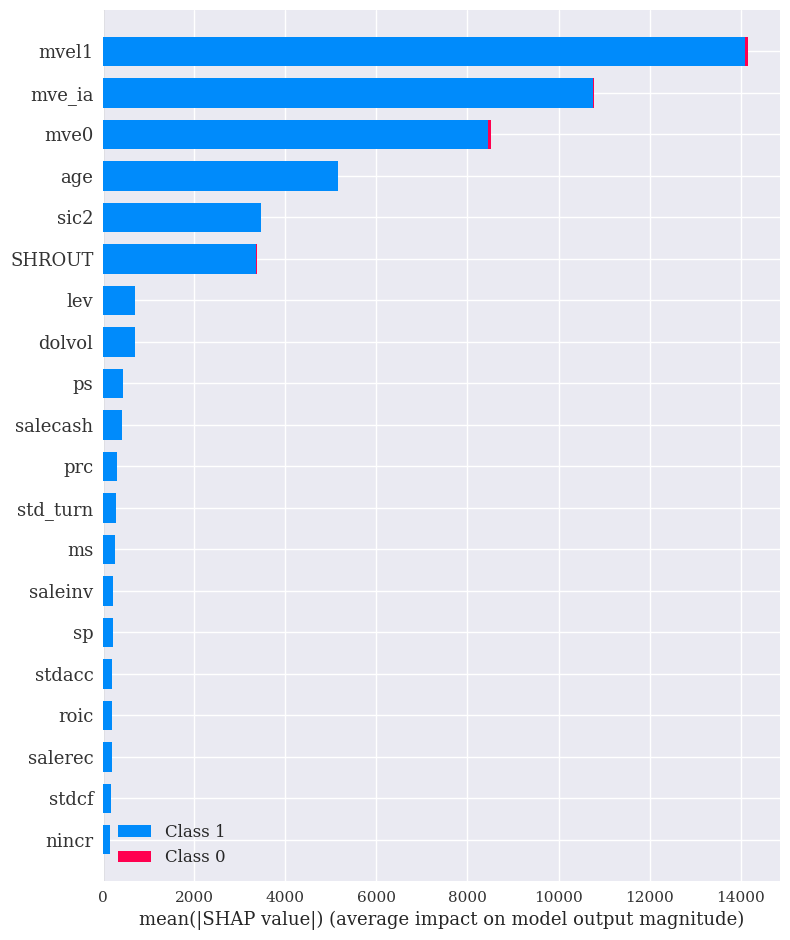

In [ ]:
# Visulize the feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")